# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../data/pre_processed_tox_rdkit.csv")
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,AvgIpc,fda_approved
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.581656,1.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.500582,1.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.713860,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559977,1.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.426037,1.0


In [4]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: fda_approved, dtype: float64

In [5]:
X = data.iloc[:, 32:-1]
X.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,FpDensityMorgan1,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,AvgIpc
0,6.055556,-0.333333,0.333333,0.242956,59.072,0.0,0.182528,-0.370334,0.370334,1.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.581656
1,9.451389,-0.439815,0.439815,0.301333,75.067,0.0,0.239711,-0.288644,0.288644,2.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.500582
2,9.229167,-0.939815,0.939815,0.256644,76.055,0.0,0.335391,-0.349891,0.349891,2.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.713860
3,4.951389,0.683642,0.683642,0.419021,77.152,0.0,0.002549,-0.329661,0.329661,1.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559977
4,9.555556,-0.611111,0.611111,0.373753,78.136,0.0,0.094572,-0.616764,0.616764,1.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.426037


In [6]:
# separate train an test datasets

np.random.seed(6752)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "rdkit"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN
x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,AvgIpc
0,1.0,-1.868622,1.098096,1.075602,-0.461650,-1.338290,-0.032507,-1.380990,0.186532,-0.341940,...,-0.213464,-0.103289,-0.092286,-0.08628,-0.150191,-0.032507,-0.111481,0.215898,-0.181207,-1.752446
1,1.0,-1.447527,0.933916,0.450900,0.512521,-0.446042,-0.032507,-0.409406,0.055453,-0.183835,...,-0.213464,-0.103289,-0.092286,-0.08628,-0.150191,-0.032507,-0.111481,-0.237600,-0.181207,-1.220131
2,1.0,-1.383493,0.967144,0.577332,0.664602,-0.160322,-0.032507,-0.697639,0.980195,-1.299235,...,-0.213464,-0.103289,-0.092286,-0.08628,-0.150191,-0.032507,-0.111481,-0.237600,-0.181207,0.129888
3,1.0,2.122969,-0.924412,-0.672420,0.209351,0.989802,-0.032507,0.411034,-0.418133,0.387392,...,-0.213464,-0.103289,-0.092286,-0.08628,-0.150191,-0.032507,-0.111481,-0.237600,-0.181207,1.136905
4,1.0,0.377689,0.420608,-0.301518,0.951995,-0.415963,-0.032507,0.675573,-0.821357,0.873751,...,-0.213464,-0.103289,-0.092286,-0.08628,-0.150191,-0.032507,-0.111481,-0.237600,-0.181207,-0.183252


In [9]:
# TEST
x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,AvgIpc
0,1.0,-0.399179,0.317062,-0.181628,0.307882,-0.943672,0.0,-1.006739,-0.712690,0.750496,...,-0.202184,-0.086249,-0.092253,-0.086249,-0.117914,0.0,-0.136281,-0.248447,-0.188113,-0.992242
1,1.0,0.058983,0.013701,-0.038935,-0.794558,2.500074,0.0,0.437945,-0.697426,0.731646,...,-0.202184,-0.086249,-0.092253,-0.086249,-0.117914,0.0,-0.136281,-0.248447,-0.188113,-0.436695
2,1.0,1.199429,0.327168,-0.165984,1.609128,0.017398,0.0,1.100824,-0.261432,0.193240,...,-0.202184,-0.086249,-0.092253,-0.086249,-0.117914,0.0,-0.136281,-0.248447,-0.188113,0.298416
3,1.0,0.384074,0.274525,-0.081417,-0.026434,0.522998,0.0,0.428641,-0.629754,0.648078,...,-0.202184,-0.086249,-0.092253,-0.086249,-0.117914,0.0,-0.136281,-0.248447,4.765538,0.664893
4,1.0,-0.016666,0.571101,-0.229878,-0.455591,-1.139215,0.0,-0.761844,0.724487,-1.024265,...,-0.202184,-0.086249,-0.092253,-0.086249,-0.117914,0.0,-0.136281,-0.248447,-0.188113,-1.533641


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train_scaled, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 14:54


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 14:54
Tempo de execução:  0.0 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.801443,{}


## Fitting Model to Train Dataset

To fit the model, I will use the Logit function, from the statsmodel library, because it gives more information about feature importance.

In [14]:
# adjusting y_train index and type

y_train.index = range(0, x_train_scaled.shape[0])

In [15]:
# calculatin model

log_reg = LogisticRegression().fit(x_train_scaled, y_train)

# log_reg = sm.Logit(y_train, x_train_scaled).fit()
# log_reg_results = log_reg.summary()

/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Make Predictions

In [16]:
y_predict_labels_lr = log_reg.predict(x_test_scaled)
y_predict_lr_prob = log_reg.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [17]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.2605


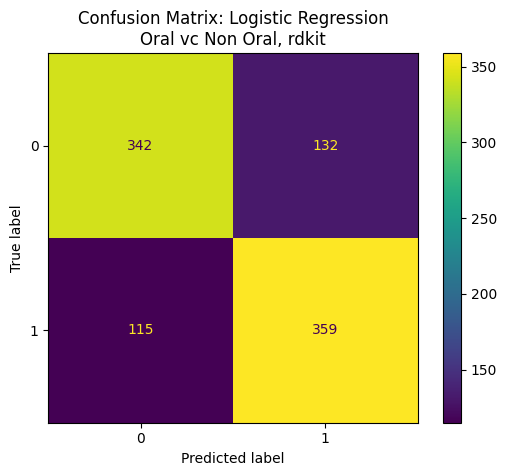

In [18]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

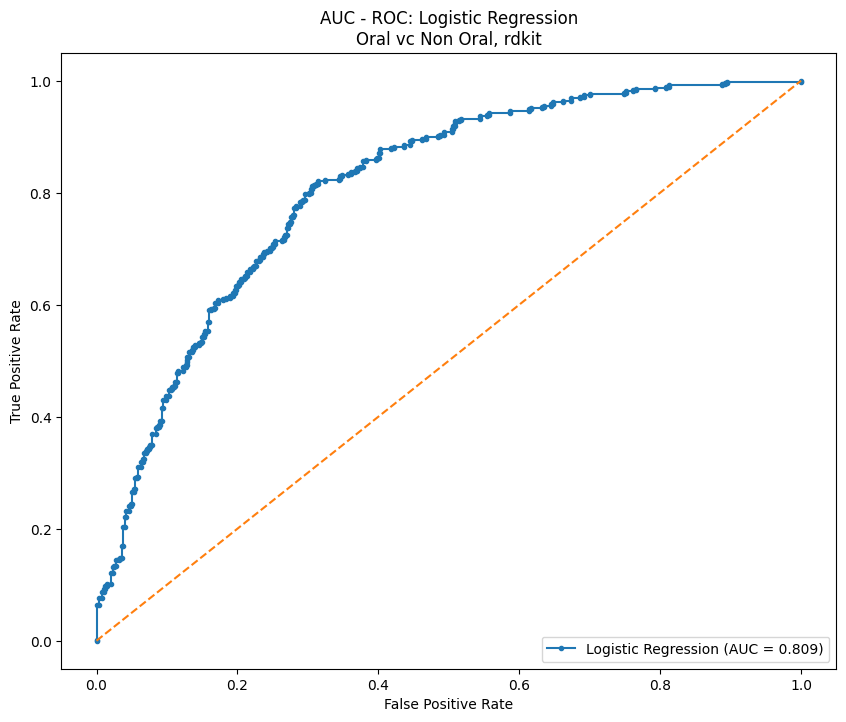

In [19]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [20]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(columns=["model_name", "cv_auc", "test_mis_rate", "test_auc"])

In [21]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr,
    auc_lr
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.801443,0.260549,0.808671


# TREES

# Decision Tree

## Model Constant Variables

In [22]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [23]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [24]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Decision Tree: 14:54
Finished Grid Search for Decision Tree: 15:00
Tempo de execução:  6.2 minutos


In [25]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.757358,"{'ccp_alpha': 0.001, 'criterion': 'entropy', '..."


## Fitting Tree

In [26]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 5}

In [27]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train_scaled, y_train)

## Make Predictions

In [28]:
y_predict_dt_label = decision_tree.predict(x_test_scaled)
y_predict_dt_prob = decision_tree.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [29]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.3101


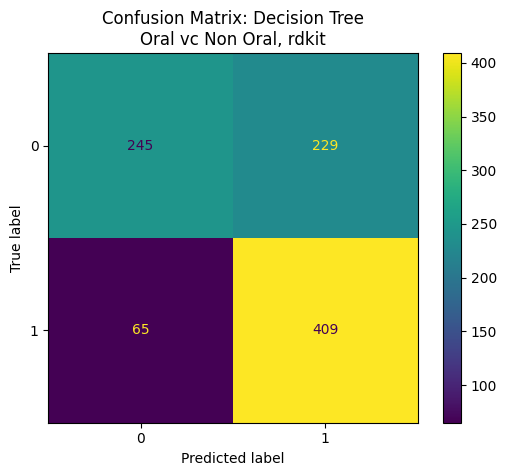

In [30]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

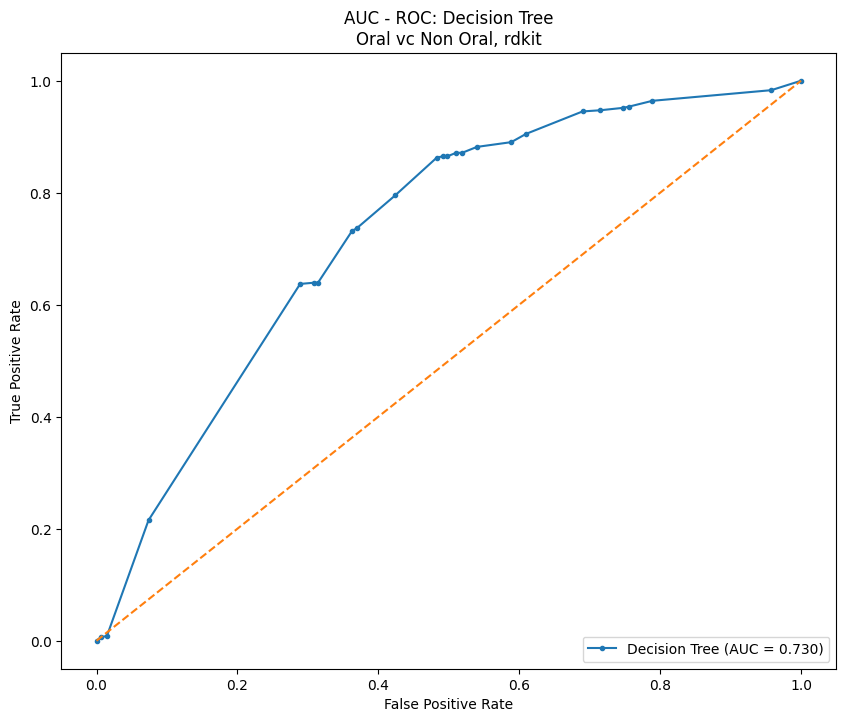

In [31]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

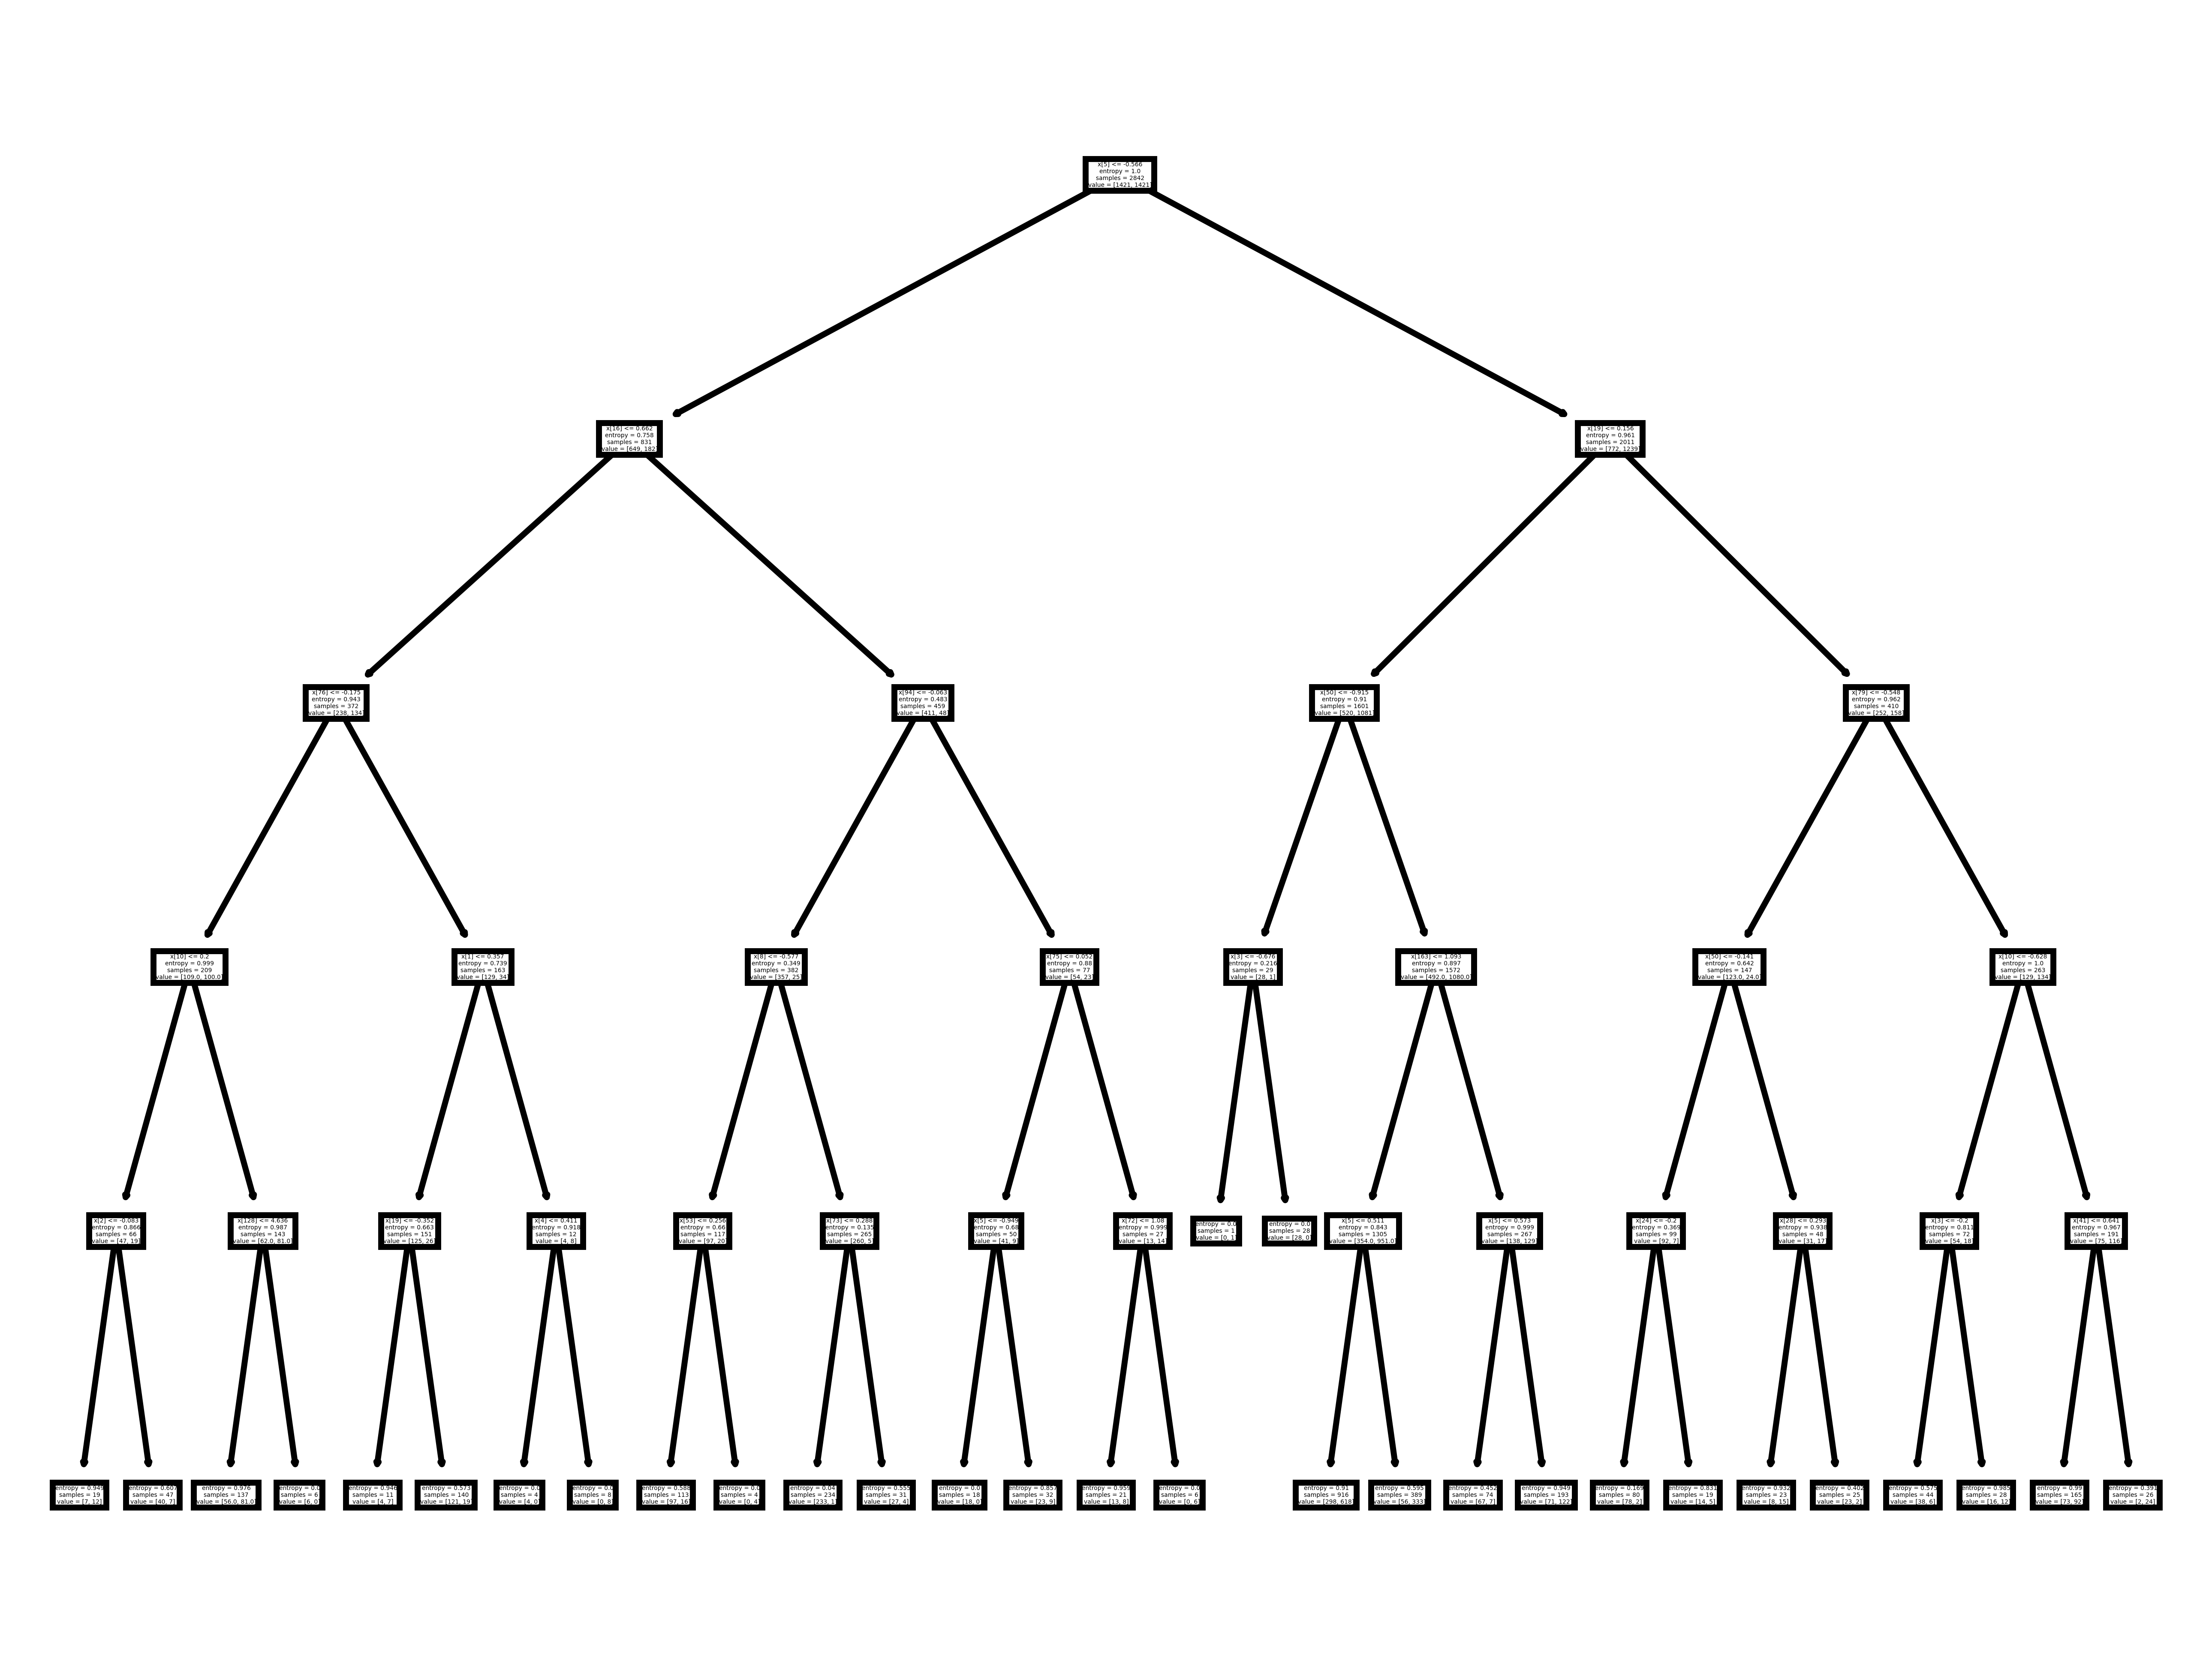

In [32]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax)
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

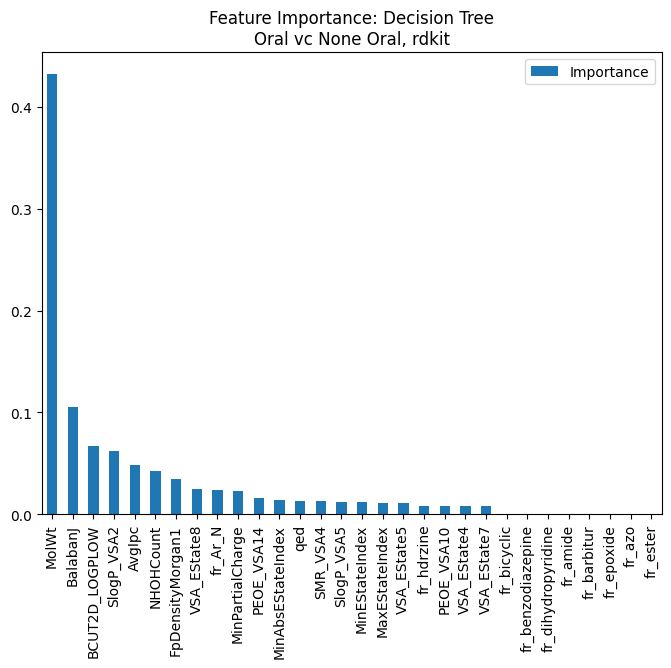

In [33]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [34]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
VSA_EState7,0.007843
VSA_EState4,0.007937
PEOE_VSA10,0.008350
fr_hdrzine,0.008683
VSA_EState5,0.010764
MaxEStateIndex,0.010833
MinEStateIndex,0.012273
SlogP_VSA5,0.012431
SMR_VSA4,0.012776
qed,0.012786


## Saving Results

In [35]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt,
    auc_dt
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.801443,0.260549,0.808671
1,Decision Tree,0.757358,0.310127,0.729722


In [36]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [37]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [38]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2", x_train.shape[1]], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5, 1]
        }
    }
}

In [39]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Random Forest: 15:00
Finished Grid Search for Random Forest: 03:40
Tempo de execução:  759.5 minutos


In [40]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.801457,"{'ccp_alpha': 0, 'max_depth': 10, 'max_feature..."


## Fitting Model

In [41]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0, 'max_depth': 10, 'max_features': 163, 'n_estimators': 1000}

In [42]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train_scaled, y_train)

## Make Predictions

In [43]:
y_predict_rf_label = random_forest.predict(x_test_scaled)
y_predict_rf_prob = random_forest.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [44]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.2627


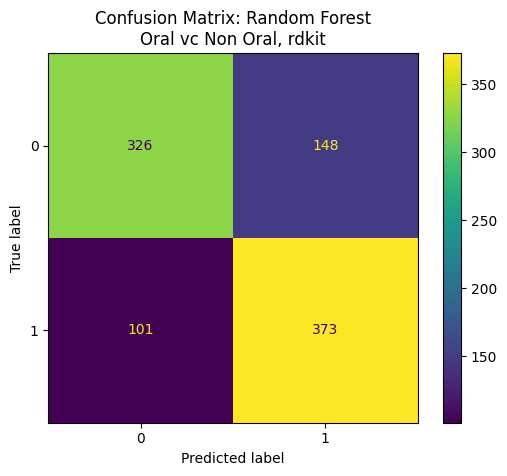

In [45]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

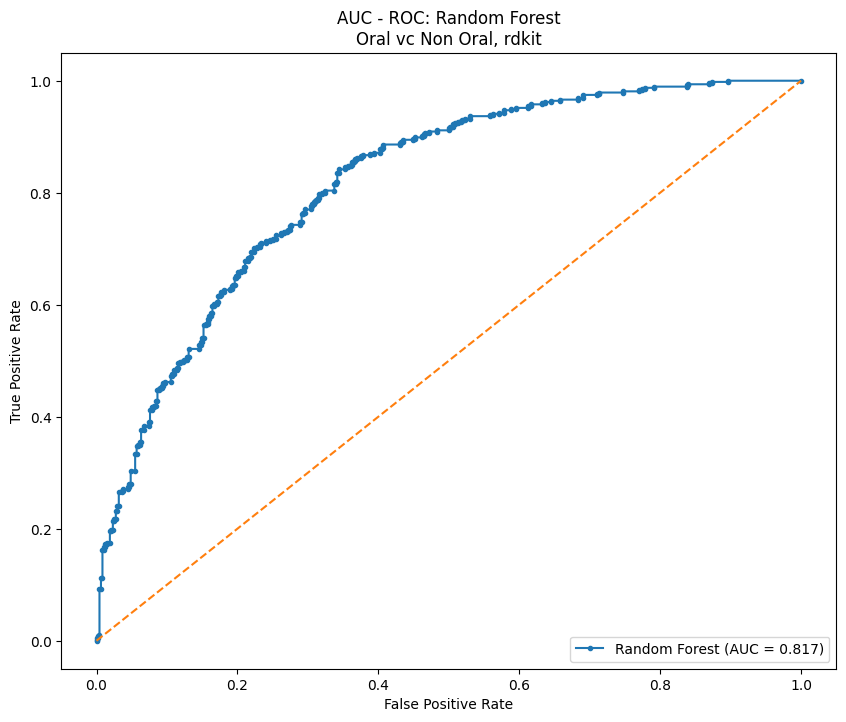

In [46]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

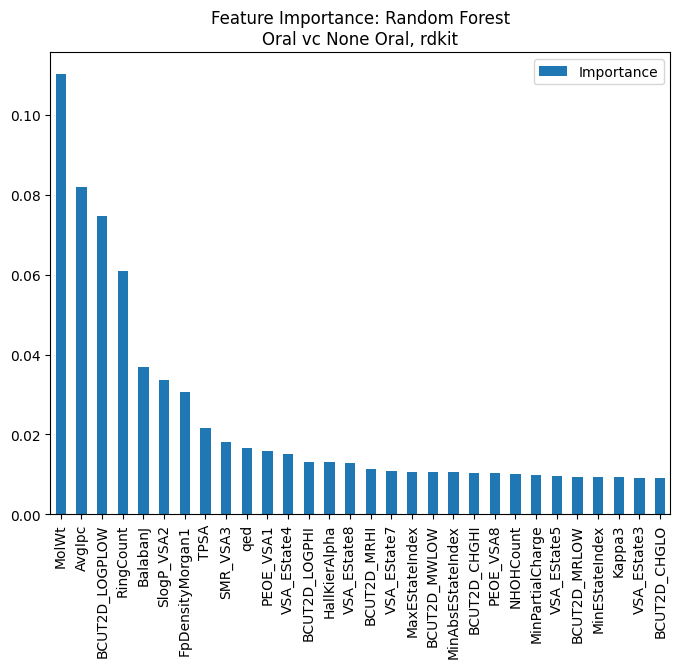

In [47]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [48]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
fr_azide,0.000002
fr_thiocyan,0.000002
NumRadicalElectrons,0.000006
Ipc,0.000008
fr_aldehyde,0.000012
...,...
BalabanJ,0.036931
RingCount,0.060913
BCUT2D_LOGPLOW,0.074548
AvgIpc,0.081971


## Saving Results

In [49]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf,
    auc_rf
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.801443,0.260549,0.808671
1,Decision Tree,0.757358,0.310127,0.729722
2,Random Forest,0.801457,0.262658,0.817010


In [50]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [51]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [52]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500, 1000], # number of trees
                'learning_rate': [0.001, 0.1, 1], # alfa
                'max_depth': [10, 20, 50],
        }
    }
}

In [53]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 03:41
Finished Grid Search for Boosting: 10:31
Tempo de execução:  409.5 minutos


In [54]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.784216,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."


## Fitting Model

In [55]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

In [56]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train_scaled, y_train)

## Make Prediction

In [57]:
y_predict_boo_label = boosting.predict(x_test_scaled)
y_predict_boo_prob = boosting.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [58]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.2679


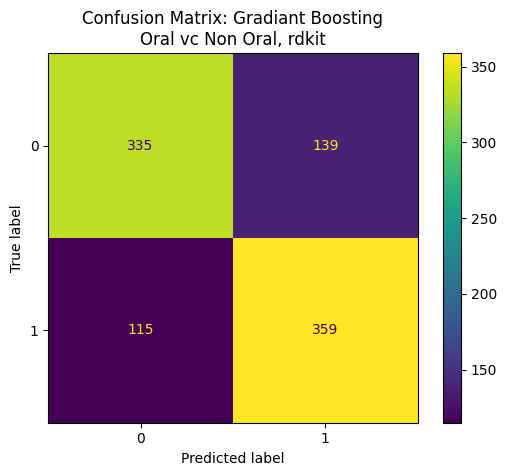

In [59]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

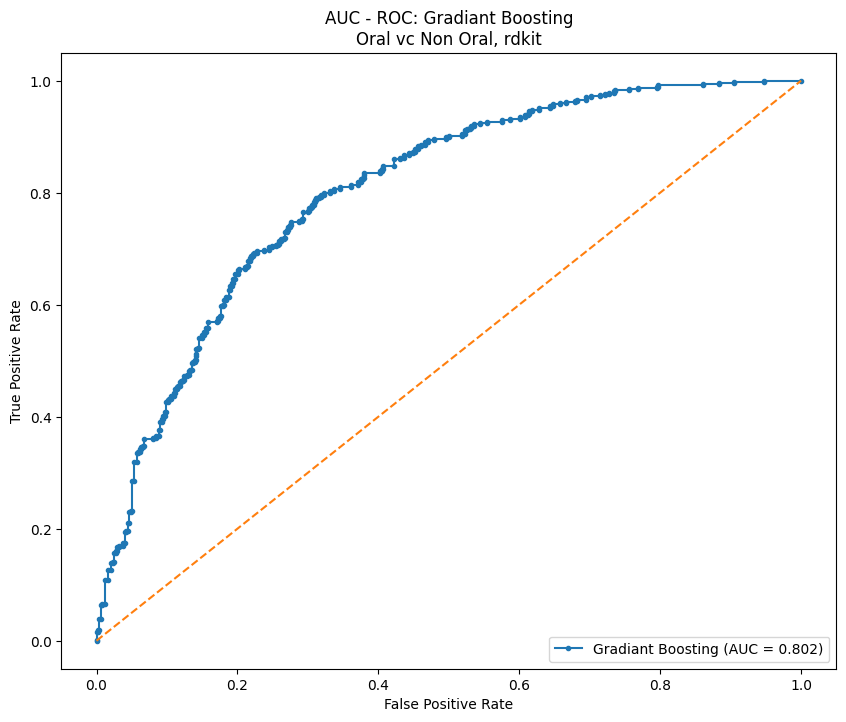

In [60]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

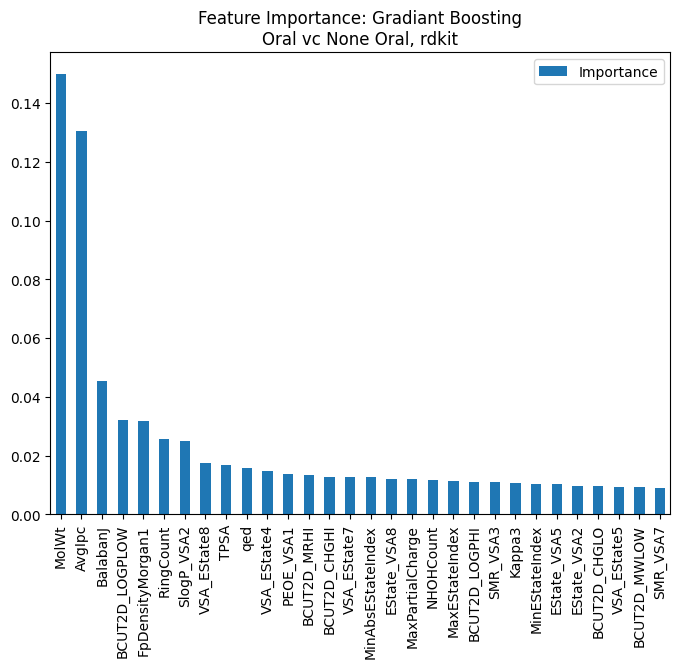

In [61]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [62]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
fr_azide,7.144500e-10
fr_aldehyde,8.952072e-10
Ipc,3.317354e-09
EState_VSA11,3.048233e-07
NumRadicalElectrons,1.075132e-06
...,...
FpDensityMorgan1,3.192473e-02
BCUT2D_LOGPLOW,3.201544e-02
BalabanJ,4.541502e-02
AvgIpc,1.303448e-01


## Saving Results

In [63]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo,
    auc_boo
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.801443,0.260549,0.808671
1,Decision Tree,0.757358,0.310127,0.729722
2,Random Forest,0.801457,0.262658,0.817010
3,Gradiant Boosting,0.784216,0.267932,0.802088


In [64]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [65]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [66]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [67]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [68]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 10:32
Finished Grid Search for BART: 16:02
Tempo de execução:  330.1 minutos


In [69]:
gs_result_bart

,model,best_score,best_params
0,BART,0.734051,"{'burnin': 20, 'max_stages': 100, 'num_trees':..."


# Fitting Model

In [70]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 20, 'max_stages': 100, 'num_trees': 1000}

In [71]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=20, max_stages=100, num_trees=1000)

## Make Prediction

In [72]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [73]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [74]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.2711


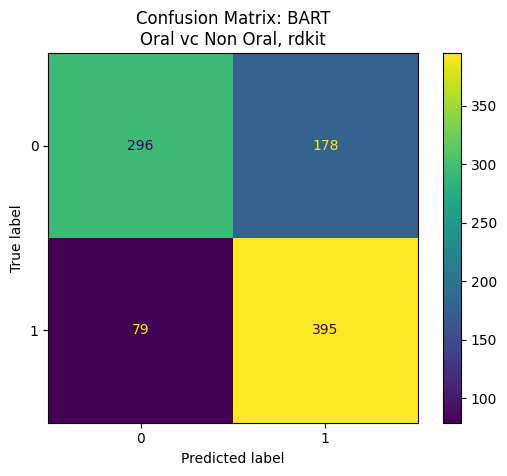

In [75]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

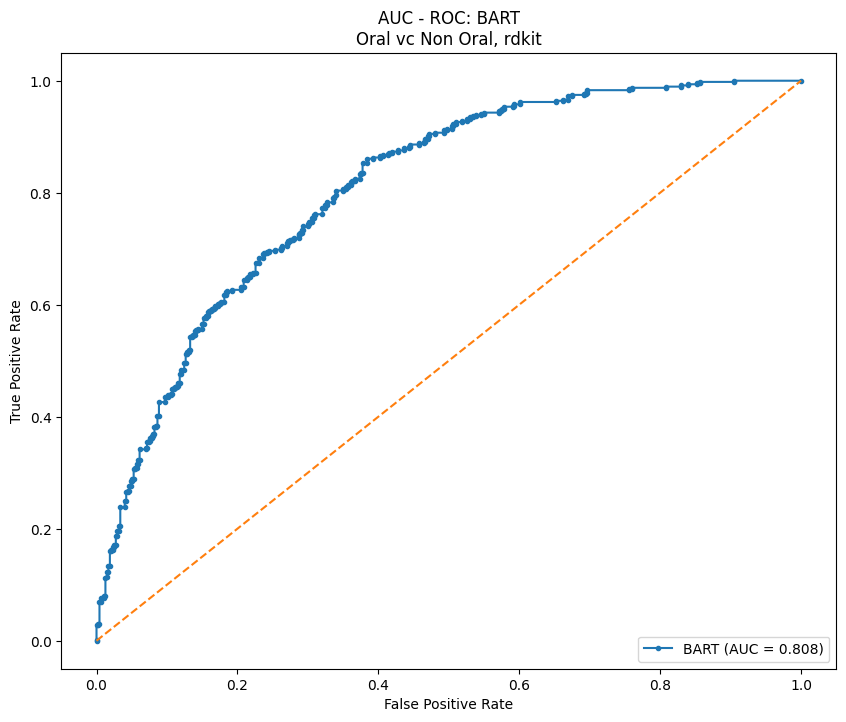

In [76]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

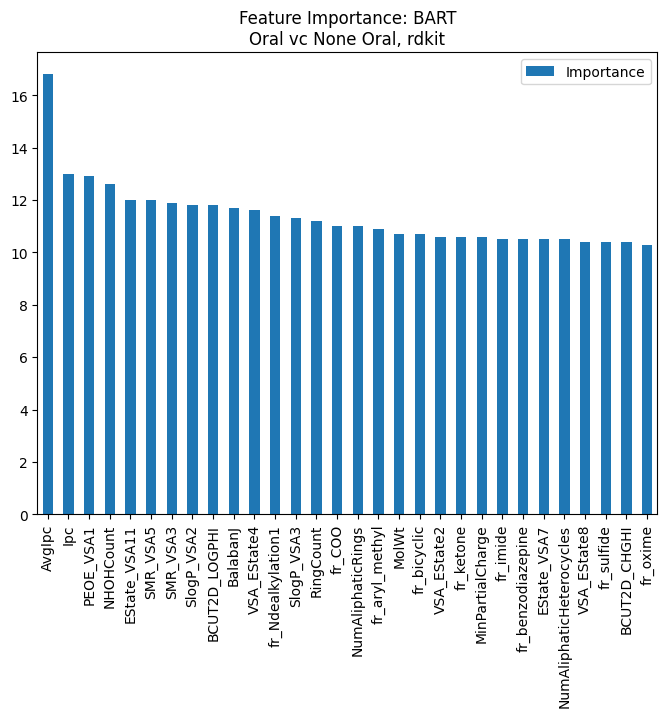

In [77]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [78]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
fr_tetrazole,6.1
VSA_EState5,6.7
SlogP_VSA11,7.1
fr_lactone,7.2
fr_urea,7.3
...,...
EState_VSA11,12.0
NHOHCount,12.6
PEOE_VSA1,12.9
Ipc,13.0


## Saving Results

In [79]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart,
    auc_bart
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.801443,0.260549,0.808671
1,Decision Tree,0.757358,0.310127,0.729722
2,Random Forest,0.801457,0.262658,0.817010
3,Gradiant Boosting,0.784216,0.267932,0.802088
4,BART,0.734051,0.271097,0.808404


In [80]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [81]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [82]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [83]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 16:03
Finished Grid Search for SVM: 16:51
Tempo de execução:  48.0 minutos


## Fitting Model

In [84]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}

In [85]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Make Prediction

In [86]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [87]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.2901


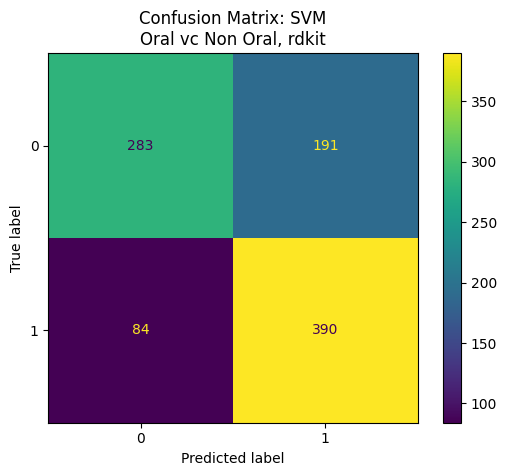

In [88]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

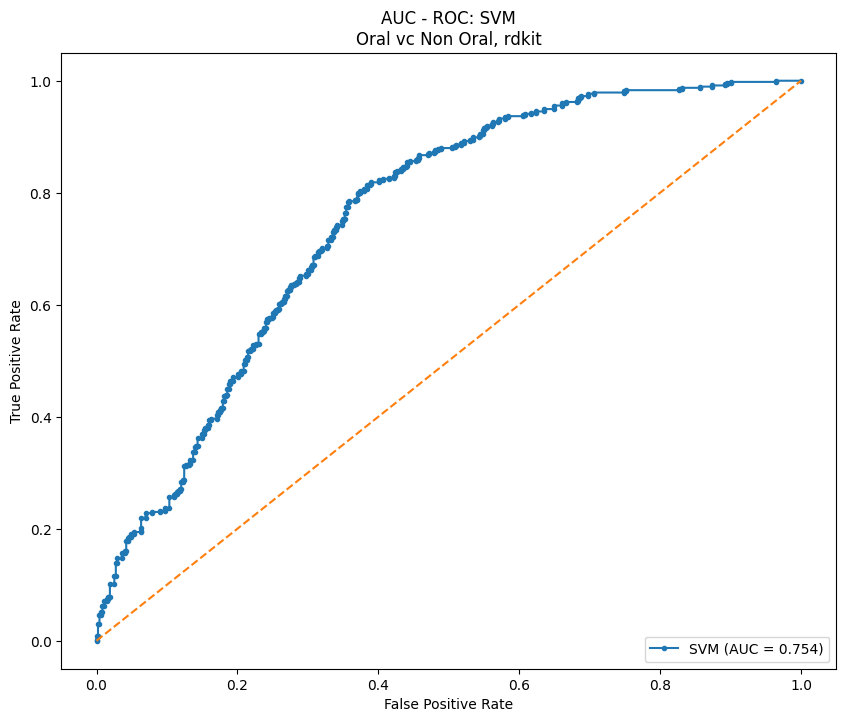

In [89]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [90]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm,
    auc_svm
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.801443,0.260549,0.808671
1,Decision Tree,0.757358,0.310127,0.729722
2,Random Forest,0.801457,0.262658,0.817010
3,Gradiant Boosting,0.784216,0.267932,0.802088
4,BART,0.734051,0.271097,0.808404
5,SVM,0.758124,0.290084,0.753894


# Saving Final Datasets

In [91]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [92]:
session_info.show()